In [1]:
using DataFrames
using StatsModels
using LibGEOS
using GaussianProcesses
using Distributions
using Revise
using GeoRDD

In [2]:
import PyPlot; 
plt=PyPlot;

In [3]:
srand(1) # for replicability
n = 300
X = rand(2, n)
f_X = sin.(X[1,:] * 2.0) .+ 3.0 .* X[2,:].^2.0
m = -0.8 # mean offset
τ = 0.3 # constant treatment effect
treatment_radius = 0.8
covarA = randn(n)
covarB = randn(n)
categ = rand(["A", "B", "C"], n) # random cateogry
treat = sqrt.(X[1,:].^2 + X[2,:].^2) .< treatment_radius

# outcome is: smooth surface + noise + treatment effect
Y = m .+ # mean offset
    f_X .+ # smooth surface
    0.3*randn(n) .+ # noise
    τ .* treat .+ # treatment effect
    covarA .* 0.1 .+ # effect of real-valued covariate
    (categ.=="B") .* 0.2 # raise category B a little bit
;

In [4]:
border_X1 = treatment_radius .* cos.(linspace(0,π/2,1000))
border_X2 = treatment_radius .* sin.(linspace(0,π/2,1000))
border_geo = LibGEOS.LineString([[border_X1[i], border_X2[i]] for i in 1:n])
;

In [5]:
geordd_df = DataFrame(
    X1 = X[1, :],
    X2 = X[2, :],
    outcome = Y,
    region = treat, # treatment indicator
    covarA = covarA,
    covarB = covarB,
    categ = categ
    )
categorical!(geordd_df, :categ)
categorical!(geordd_df, :region)
fmla = @formula(outcome ~ GP(X1, X2) | region + covarA + covarB + categ)
geordd = GeoRDD.regions_from_dataframe(fmla, geordd_df)
;

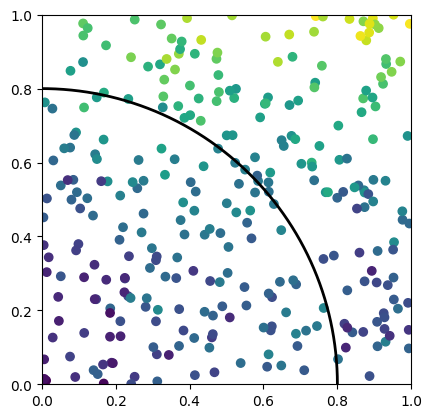

In [6]:
# plot the data and the border
plt.plot(border_X1, border_X2, color="black", linewidth=2)
plt.scatter(geordd_df[:X1], geordd_df[:X2], c=Y)
ax = plt.gca()
plt.xlim(0,1)
plt.ylim(0,1)
ax[:set_aspect]("equal")
;

In [7]:
# choose a Gaussian process kernel from the GaussianProcesses.jl package
k_se = SEIso(log(0.5), log(1.0)) # Squared Exponential spatial kernel
k_m = Const(log(20.0))           # constant kernel for the mean parameters
βkern = LinIso(log(1.0))         # linear kernel for the other covariates
logNoise = 1.0
# create the Gaussian process object from the regional data:
mgpcv = GeoRDD.MultiGPCovars(geordd, k_se+k_m, βkern, logNoise)
;

In [8]:
# optimize the hyperparameters
@time opt_output=optimize!(
        mgpcv, 
        noise=true,
        kern=true,
        domean=false,
        beta=true,
        options=Optim.Options(
            show_trace=false,
            iterations=1000,
            x_tol=1e-8,
            f_tol=1e-10),
    )
opt_output

  4.833847 seconds (3.52 M allocations: 177.254 MiB, 1.83% gc time)


Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,-0.6931471805599453, ...]
 * Minimizer: [-1.1643314110026532,-0.18843771008996912, ...]
 * Minimum: 1.107689e+02
 * Iterations: 180
 * Convergence: true
   * |x - x'| ≤ 1.0e-08: false 
     |x - x'| = 2.53e-05 
   * |f(x) - f(x')| ≤ 1.0e-10 |f(x)|: true
     |f(x) - f(x')| = 9.59e-11 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.16e-03 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 370
 * Gradient Calls: 194

In [9]:
# fitted hyperparameters
@printf("σ_y: %.4f\n", exp(mgpcv.logNoise))
@printf("σ_f: %.4f\n", √(mgpcv.k.kleft.σ2))
@printf("σ_β: %.4f\n", 1/√mgpcv.βkern.ℓ2)
ℓ = √(mgpcv.k.kleft.ℓ2)
@printf("ℓ: %.4f\n", ℓ)

σ_y: 0.3121
σ_f: 1.9145
σ_β: 0.0885
ℓ: 0.8283


In [10]:
# extract posterior mean of linear regression coefficients
βhat = GeoRDD.postmean_β(mgpcv)
# extract residuals
residuals_rd = similar(geordd)
residuals_rd[true]  = GeoRDD.residuals_data(geordd[true],  βhat) # treatment region
residuals_rd[false] = GeoRDD.residuals_data(geordd[false], βhat) # control region
# Gaussian processes fitted to residuals:
resid_GP_dict = GeoRDD.GPRealisations(residuals_rd, mgpcv.k, exp(mgpcv.logNoise))
;

In [11]:
# obtain posterior treatment effect along border
T,C = true, false
sentinels = GeoRDD.sentinels(border_geo, 100)
μpost, Σpost = GeoRDD.cliff_face(resid_GP_dict[T], 
                                 resid_GP_dict[C],
                                 sentinels)
;

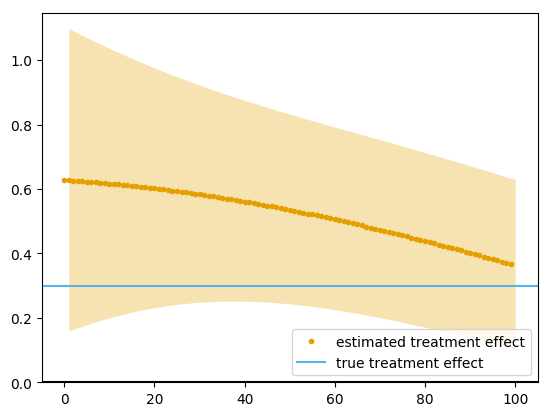

In [12]:
# plot cliff-face
let
    μ = μpost
    Σ = Σpost
    color = "#E69F00"
    plt.plot(μ, color=color, ".", label="estimated treatment effect")
    posterior_sd = sqrt.(diag(Σ))
    plt.fill_between(1:length(μ), μ.-2*posterior_sd, μ.+2*posterior_sd, 
        color=color, 
        alpha=0.3,
        linewidth=0,
        )
    plt.ylim(0)
    plt.axhline(0.0, color="black")
    plt.axhline(τ, color="#56B4E9", label="true treatment effect")
    plt.legend(loc="lower right")
end
;

In [13]:
# average treatment effect

println("inverse-variance weighted LATE")
println("==============================")
τ_inv=GeoRDD.inverse_variance(μpost, Σpost)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_inv), std(τ_inv))
@printf("P(τ<0|Y) = %.3f%%\n", cdf(τ_inv, 0.0)*100)

println("")

println("projected finite-population LATE")
println("================================")
maxdist = 2ℓ
τ_proj = GeoRDD.proj_estimator(resid_GP_dict[T], 
                               resid_GP_dict[C], 
                               border_geo,
                               2ℓ)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_proj), std(τ_proj))
@printf("P(τ<0|Y) = %.3f%%", cdf(τ_proj, 0.0)*100)

inverse-variance weighted LATE
τ|Y ∼ Normal(μ=0.263, σ=0.102)
P(τ<0|Y) = 0.501%

projected finite-population LATE
τ|Y ∼ Normal(μ=0.408, σ=0.128)
P(τ<0|Y) = 0.071%

In [14]:
# significance test
pval_invvar_calib = GeoRDD.pval_invvar_calib(
    resid_GP_dict[T],
    resid_GP_dict[C],
    sentinels
)

0.008817773501554164